# <center> Baseline ResNet

Nous allons utiliser ResNet pour nous créer une baseline de comparaison, mais également pour comparer les performances avec la partie vision.

## Imports de base

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
from pathlib import Path

# Pour que notre archi fonctionne avec google colab 
    
!git clone https://github.com/TON_USERNAME/Reconnaissance-de-mouvement-artistique.git
!cd /content/Reconnaissance-de-mouvement-artistique && git pull
%cd /content/Reconnaissance-de-mouvement-artistique 
import sys
sys.path.append(".")  # pour que src/ soit importable

PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))

fatal: destination path 'Reconnaissance-de-mouvement-artistique' already exists and is not an empty directory.
Already up to date.
/content/Reconnaissance-de-mouvement-artistique


In [ ]:
from src.dataset_dl import ArtDataset
from src.train import train_model

from src.dataset import load_df_train_test_val, load_df
from src.preprocessing import clean_dataset

from src.models import get_resnet18
from src.evaluate import compute_confusion_matrix, plot_confusion_matrix, accuracy_per_class, visualize_accuracy_per_style
from src.utils import set_seed

#Fixer l'initialisation aléatoire pour la reproductibilité
set_seed(42)

#pour avoir acces au GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


In [4]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path

PROJECT_ROOT = Path("/content/deepl-projet")
DATA_ROOT = Path("/content/drive/MyDrive/DeepLearning/WikiArt_Subset")


df_test, df_train, df_val = load_df_train_test_val(DATA_ROOT)
df = load_df(DATA_ROOT)

df, df_train, df_val, df_test = clean_dataset(df, df_train, df_val, df_test)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/Reconnaissance-de-mouvement-artistique/src/preprocessing.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["style_encoded"] = le.fit_transform(df_train["style"])
/content/Reconnaissance-de-mouvement-artistique/src/preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["style_encoded"]   = le.transform(df_val["style"])
/content/Reconnaissance-de-mouvement-artistique/src/preprocessing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

## 1. Partie Classique / Baseline

### 1.1 Préparation du dataset

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [6]:
IMAGE_ROOT_TRAIN = DATA_ROOT / "train"
IMAGE_ROOT_VAL = DATA_ROOT / "val"

train_dataset = ArtDataset(
    df_train,
    IMAGE_ROOT_TRAIN,
    transform=transform
)

val_dataset = ArtDataset(
    df_val,
    IMAGE_ROOT_VAL,
    transform=transform
)


In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False
)


### 1.2 Charger le modèle

In [8]:
num_classes = df_train["style"].nunique()
print("Min label:", df_train["style"].min())
print("Max label:", df_train["style"].max())
print("Nombre de classes uniques:", df_train["style"].nunique())


print(str(df_train["style"].nunique()))
model = get_resnet18(num_classes=num_classes, device=device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.fc.parameters(),
    lr=1e-3
)


Min label: 0
Max label: 26
Nombre de classes uniques: 23
23


### 1.3 Entrainement du modèle

On commence avec 3 epoch et on freeze.

In [9]:
row = df_train.iloc[0]

print(row["filename"])
print(row["style"])
print(row["style_encoded"])

print(row["style_name"])
print(df_train[["style","style_name"]].head(10))

print((IMAGE_ROOT_TRAIN / str(row["style"]) / row["filename"]).exists())
print((IMAGE_ROOT_TRAIN / str(row["style_encoded"]) / row["filename"]).exists())

2289.jpg
9
7
Expressionism
    style              style_name
1       9           Expressionism
2      10                 Fauvism
4      24               Symbolism
5       0  Abstract_Expressionism
6      10                 Fauvism
7      11        High_Renaissance
8       5    Color_Field_Painting
9      26                 Ukiyo_e
10      6    Contemporary_Realism
11      9           Expressionism
True
False


In [11]:
history_freeze = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=3
)



Epoch 1/3


Train Loss: 2.5325 | Train Acc: 0.2403 | Val Loss: 2.1950 | Val Acc: 0.3365

Epoch 2/3


Train Loss: 2.0217 | Train Acc: 0.3813 | Val Loss: 1.9835 | Val Acc: 0.4050

Epoch 3/3


Train Loss: 1.8507 | Train Acc: 0.4289 | Val Loss: 1.9208 | Val Acc: 0.4115


unfreeze complet :

In [12]:
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4
)


On continue avec cette fois 10 epoch.

In [13]:
history_unfreeze = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=10
)



Epoch 1/10


Train Loss: 1.6170 | Train Acc: 0.4850 | Val Loss: 1.5780 | Val Acc: 0.4916

Epoch 2/10


Train Loss: 0.7173 | Train Acc: 0.8063 | Val Loss: 1.5630 | Val Acc: 0.5178

Epoch 3/10


Train Loss: 0.2744 | Train Acc: 0.9578 | Val Loss: 1.5616 | Val Acc: 0.5324

Epoch 4/10


Train Loss: 0.1011 | Train Acc: 0.9927 | Val Loss: 1.5817 | Val Acc: 0.5375

Epoch 5/10


Train Loss: 0.0528 | Train Acc: 0.9949 | Val Loss: 1.6125 | Val Acc: 0.5492

Epoch 6/10


Train Loss: 0.0346 | Train Acc: 0.9964 | Val Loss: 1.6431 | Val Acc: 0.5484

Epoch 7/10


Train Loss: 0.0292 | Train Acc: 0.9963 | Val Loss: 1.6805 | Val Acc: 0.5441

Epoch 8/10


Train Loss: 0.0253 | Train Acc: 0.9953 | Val Loss: 1.6976 | Val Acc: 0.5492

Epoch 9/10


Train Loss: 0.0202 | Train Acc: 0.9961 | Val Loss: 1.7473 | Val Acc: 0.5448

Epoch 10/10


Train Loss: 0.0349 | Train Acc: 0.9918 | Val Loss: 1.9127 | Val Acc: 0.5084


### 1.4 Evaluation du modèle

Accuracy (précision)  globale :

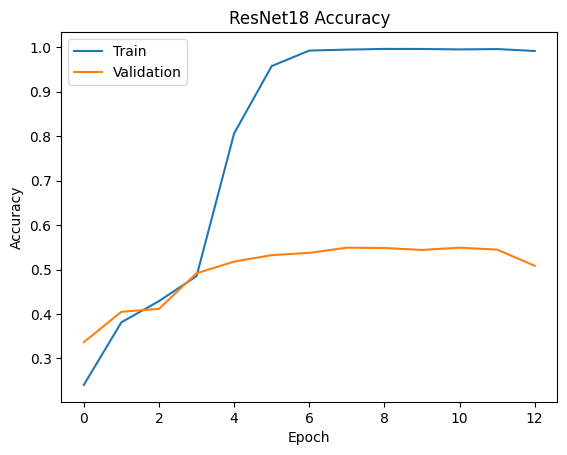

In [14]:
train_acc = history_freeze["train_acc"] + history_unfreeze["train_acc"]
val_acc   = history_freeze["val_acc"]   + history_unfreeze["val_acc"]

plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["Train", "Validation"])
plt.title("ResNet18 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


Matrice de confusion :

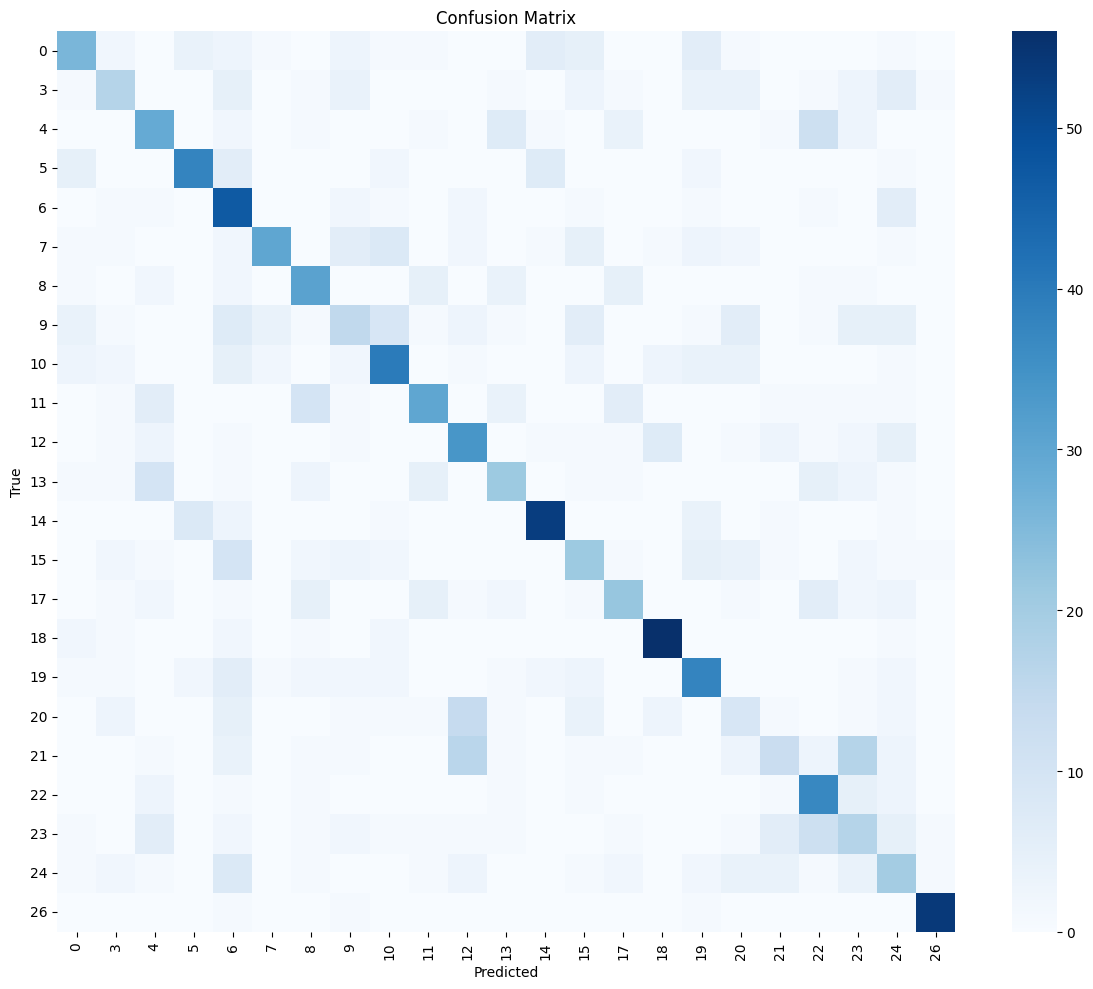

In [15]:
#Confusion matrix :

class_names = sorted(df_train["style"].unique())

cm = compute_confusion_matrix(
    model,
    val_loader,
    device,
    class_names
)

plot_confusion_matrix(cm, class_names)


Accuracy par style :

In [16]:
class_names = sorted(df_train["style"].unique())

acc_per_style = accuracy_per_class(
    model,
    val_loader,
    device,
    class_names
)

results = list(zip(class_names, acc_per_style))
results = sorted(results, key=lambda x: x[1], reverse=True)

for style, acc in results:
    print(f"{style}: {acc:.3f}")


26: 0.947
18: 0.862
14: 0.746
6: 0.746
22: 0.698
5: 0.623
8: 0.596
19: 0.594
10: 0.571
12: 0.548
11: 0.484
7: 0.476
4: 0.475
0: 0.433
17: 0.423
13: 0.396
15: 0.375
24: 0.357
3: 0.327
23: 0.288
9: 0.214
21: 0.200
20: 0.196


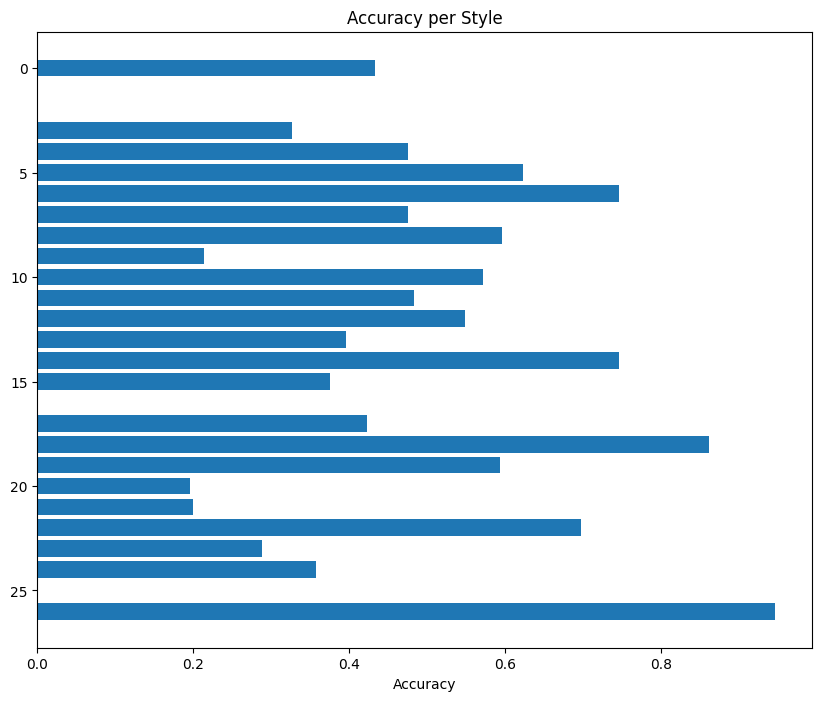

In [17]:
visualize_accuracy_per_style(results)

### 1.5 Sauvegarde du modèle entrainé

In [18]:
torch.save(model.state_dict(), "resnet18_baseline.pt")



🔹 Phase B – Préparer l’infrastructure pour ablation

 Créer fonction apply_low_pass(image)

 Créer fonction apply_high_pass(image)

 Version dataset avec filtrage optionnel

 Réentraîner ResNet sur chaque version

 Comparer accuracy globale

 Comparer accuracy par style

 Graphique comparatif final